In [1]:
R.version

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          4.2                              
year           2024                             
month          10                               
day            31                               
svn rev        87279                            
language       R                                
version.string R version 4.4.2 (2024-10-31 ucrt)
nickname       Pile of Leaves                   

# 1. Initialization

In [4]:
# PACKAGES & CONSTANTS DECLARATIONS #
#####################################

# Function to install missing packages
InstallPackages <- function(oPackageList) {
  for (sPackage in oPackageList) {
    if (!require(sPackage, character.only = TRUE)) {
      install.packages(sPackage, repos = "http://cran.r-project.org")
      library(sPackage, character.only = TRUE)
    }
  }
}

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# List of required packages
oRequiredPackages <- c("sfsmisc","sparsepca", "elasticnet","reshape2", "ggplot2", "tidyr", "dplyr", "MASS", "Matrix", "stats", "doParallel")

# Install missing packages
InstallPackages(oRequiredPackages)

global_iRandomSeed <- 13654
set.seed(global_iRandomSeed)  # for reproducibility

# Constants for data dimensions
N_OBSERVATIONS <- 600
N_VARIABLES <- 1200
global_UseParallelization = 1
global_bZeroImputationBehaviour = 1
global_TrainTestRatio = 0.7

# If needed, enable CPU cores parallelization #
if (global_UseParallelization == 1) {
    library(doParallel)
    global_iCoreNumber <- detectCores() - 1
    registerDoParallel(cores = global_iCoreNumber)
}

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 20:00:59"


Le chargement a nécessité le package : sfsmisc

Le chargement a nécessité le package : sparsepca

Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.3


Registered S3 method overwritten by 'elasticnet':
  method     from     
  print.spca sparsepca


Attachement du package : 'elasticnet'


L'objet suivant est masqué depuis 'package:sparsepca':

    spca


Le chargement a nécessité le package : reshape2

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : tidyr


Attachement du package : 'tidyr'


L'objet suivant est masqué depuis 'package:reshape2':

    smiths


Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:sfsmisc':

    last


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union


Le chargement 

[1] "Current Time : 2024-12-08 20:01:00"
[1] "Duration : 1.639 seconds"


# 2. Data Generation

In [6]:
Get_Preprocessed_Data <- function(oDataSet) {
  Get_the_Mode <- function(x) {
    ux <- unique(na.omit(x))
    ux[which.max(tabulate(match(x, ux)))]
  }

  if (global_bZeroImputationBehaviour == 1) {
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else((is.na(.) | (. == 0)), mean(., na.rm = TRUE), .)))
  } else if (global_bZeroImputationBehaviour == 0) {    
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else(is.na(.), mean(., na.rm = TRUE), .)))
  }

  # Replace NA by the mode.
  oDataSet <- oDataSet %>%
    mutate(across(where(is.factor), ~ if_else(is.na(.), Get_the_Mode(.), .)))

  return(oDataSet)
}

In [8]:
# DATASET 03 => Breast Cancer                  #
################################################

# Based on thos article : https://www.bioconductor.org/packages/devel/bioc/vignettes/PCAtools/inst/doc/PCAtools.html#download-the-package-from-bioconductor

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}
BiocManager::install(c("Biobase", "GEOquery"))

library(Biobase)
library(GEOquery)

# Loading data from GEO
gset <- getGEO('GSE2990', GSEMatrix = TRUE, getGPL = FALSE)

# Extraction de la matrice d'expression
mat <- exprs(gset[[1]])

# Cleaning Affymetrix probes
mat <- mat[-grep('^AFFX', rownames(mat)),]

# Extraction metadata
idx <- which(colnames(pData(gset[[1]])) %in%
    c('relation', 'age:ch1', 'distant rfs:ch1', 'er:ch1',
      'ggi:ch1', 'grade:ch1', 'size:ch1',
      'time rfs:ch1'))
metadata <- data.frame(pData(gset[[1]])[, idx],
                       row.names = rownames(pData(gset[[1]])))

colnames(metadata) <- c('Study', 'Age', 'Distant.RFS', 'ER', 'GGI', 'Grade',
                        'Size', 'Time.RFS')

metadata$Study <- gsub('Reanalyzed by: ', '', as.character(metadata$Study))
metadata$Age <- as.numeric(gsub('^KJ', NA, as.character(metadata$Age)))
metadata$Distant.RFS <- factor(metadata$Distant.RFS, levels = c(0, 1))
metadata$ER <- factor(gsub('\\?', NA, as.character(metadata$ER)),
                      levels = c(0, 1))
metadata$ER <- factor(ifelse(metadata$ER == 1, 'ER+', 'ER-'),
                      levels = c('ER-', 'ER+'))
metadata$GGI <- as.numeric(as.character(metadata$GGI))
metadata$Grade <- factor(gsub('\\?', NA, as.character(metadata$Grade)),
                         levels = c(1, 2, 3))
metadata$Grade <- gsub(1, 'Grade 1', gsub(2, 'Grade 2', gsub(3, 'Grade 3', metadata$Grade)))
metadata$Grade <- factor(metadata$Grade, levels = c('Grade 1', 'Grade 2', 'Grade 3'))
metadata$Size <- as.numeric(as.character(metadata$Size))
metadata$Time.RFS <- as.numeric(gsub('^KJX|^KJ', NA, metadata$Time.RFS))

discard <- apply(metadata, 1, function(x) any(is.na(x)))
metadata <- metadata[!discard,]

mat <- mat[, which(colnames(mat) %in% rownames(metadata))]

if (!all(colnames(mat) == rownames(metadata))) {
    stop("Les noms des échantillons ne correspondent pas exactement entre les métadonnées et la matrice d'expression.")
}

oDataMatrix <- as.data.frame(mat)

if (!is.null(oDataMatrix)) {
  oDataMatrix <- oDataMatrix[, sapply(oDataMatrix, is.numeric), drop = FALSE]
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, as.double))
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, function(col) as.numeric(as.character(col))))
  if (any(is.na(oDataMatrix))) {
    warning("NA detected after conversion. Rows with NA will be removed.")
    oDataMatrix <- na.omit(oDataMatrix)
  }
} else {
  stop("oDataMatrix is NULL. Please provide a valid dataset.")
}

# !!!!!!!!!! GENOMIC DATA HERE. MATRIX MUST BE INVERTED !!
oDataMatrix <- as.matrix(oDataMatrix)
oDataMatrix <- t(oDataMatrix)

# Preprocessing
oDataMatrix <- as.data.frame(oDataMatrix)                                      
oDataMatrix <- Get_Preprocessed_Data(oDataMatrix)
                                      
cat("Dimensions Matrix : ", dim(mat), "\n")
head(oDataMatrix)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 20:01:06"


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Biobase' 'GEOquery'"
Old packages: 'bit', 'cluster', 'cpp11', 'data.table', 'later', 'promises',
  'quantreg'

Le chargement a nécessité le package : BiocGenerics


Attachement du package : 'BiocGenerics'


Les objets suivants sont masqués depuis 'package:dplyr':

    combine, intersect, setdiff, union


Les objets suivants sont masqués depuis 'package:stats':

    IQR, mad, sd, var, xtabs


Les objets suivants sont masqués depuis 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, gr

Dimensions Matrix :  22215 91 


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V22206,V22207,V22208,V22209,V22210,V22211,V22212,V22213,V22214,V22215
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM65752,11.41794,7.379692,7.993892,9.358754,4.532913,7.647977,6.057364,5.476293,6.687095,4.114703,⋯,9.128231,4.304479,7.740695,7.378703,6.870567,6.915892,8.253669,7.726167,8.230192,8.066488
GSM65753,11.46631,6.915186,7.316317,9.179772,4.447458,8.534378,6.096342,5.579661,6.617744,4.399629,⋯,9.002039,4.369716,7.705180,7.550226,7.029046,7.016964,8.372250,9.135737,8.000797,8.067419
GSM65755,10.84355,7.369199,7.234621,9.242987,4.419171,7.606492,5.945850,5.681318,7.028149,4.643620,⋯,9.501494,4.342873,7.282604,7.578541,7.532717,6.979739,9.709717,8.933651,8.107783,8.273684
GSM65757,11.70550,7.071089,7.489355,9.281594,4.363968,8.227871,6.128755,5.415151,7.055215,4.220379,⋯,9.062234,4.373456,7.270439,7.627284,7.031372,6.865948,8.260623,8.821008,8.088852,8.067923
GSM65758,10.86930,6.910977,7.634307,9.304971,4.366959,8.582203,6.238660,5.519744,8.936577,4.354794,⋯,9.436139,4.327564,7.166437,7.469520,6.892748,7.429310,8.173837,8.855374,8.183544,7.983323
GSM65760,11.06595,6.776827,7.256335,9.518042,4.619477,8.709101,6.149542,5.606841,8.803814,4.617739,⋯,9.266729,4.667726,7.215724,7.909284,7.763343,6.486808,7.378891,8.707212,8.341625,7.912432


[1] "Current Time : 2024-12-08 20:01:35"
[1] "Duration : 29.482 seconds"


# 3. Data Exploration

In [12]:
# Define train and test sets             #
##########################################

iTrainIndices <- sample(1:nrow(oDataMatrix), size = global_TrainTestRatio * nrow(oDataMatrix))
oTrainData <- oDataMatrix[iTrainIndices, ]
oTestData <- oDataMatrix[-iTrainIndices, ]  # Remaining data for testing

In [14]:
dim(oDataMatrix)
dim(oTrainData)
dim(oTestData)

cat("Colunms : ", colnames(oDataMatrix), "\n")

[1]    91 22215

[1]    63 22215

[1]    28 22215

Colunms :  V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 V29 V30 V31 V32 V33 V34 V35 V36 V37 V38 V39 V40 V41 V42 V43 V44 V45 V46 V47 V48 V49 V50 V51 V52 V53 V54 V55 V56 V57 V58 V59 V60 V61 V62 V63 V64 V65 V66 V67 V68 V69 V70 V71 V72 V73 V74 V75 V76 V77 V78 V79 V80 V81 V82 V83 V84 V85 V86 V87 V88 V89 V90 V91 V92 V93 V94 V95 V96 V97 V98 V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126 V127 V128 V129 V130 V131 V132 V133 V134 V135 V136 V137 V138 V139 V140 V141 V142 V143 V144 V145 V146 V147 V148 V149 V150 V151 V152 V153 V154 V155 V156 V157 V158 V159 V160 V161 V162 V163 V164 V165 V166 V167 V168 V169 V170 V171 V172 V173 V174 V175 V176 V177 V178 V179 V180 V181 V182 V183 V184 V185 V186 V187 V188 V189 V190 V191 V192 V193 V194 V195 V196 V197 V198 V199 V200 V201 V202 V203 V204 V205 V206 V207 V208 V209 V210 V211 V212 V213 V214 V215 V216 V217 V218 V219 V2

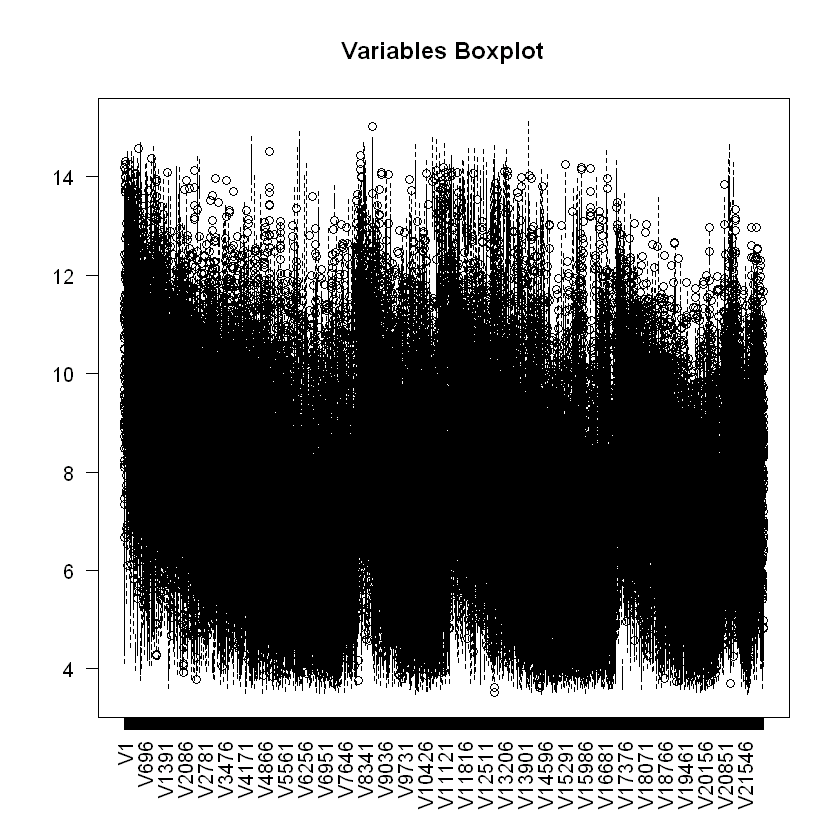

In [16]:
boxplot(oDataMatrix, las = 2, col = rainbow(ncol(oDataMatrix)), main = "Variables Boxplot")

In [ ]:
##########################################
# Correlation Matrix                     #
##########################################

cor_matrix <- cor(oDataMatrix)

# Correlations Heatmap
heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("blue", "white", "red"))(100),
        main = "Correlations Heatmap")

In [ ]:
##########################################
# Histograms for each variable           #
##########################################

par(mfrow = c(3, 3))  # Arrange plots in a grid
for (col in colnames(oDataMatrix)) {
    hist(oDataMatrix[, col], main = paste("Histogram of", col), xlab = col, col = "lightblue", border = "white")
}
par(mfrow = c(1, 1))  # Reset plot layout


In [ ]:
##########################################
# PCA Simple                             #
##########################################

pca_res <- prcomp(oDataMatrix, center = TRUE, scale. = TRUE)

# Summary of principal components
summary(pca_res)

# Biplot of the first two principal components
biplot(pca_res, main = "PCA Biplot", col = c("blue", "red"))


In [ ]:
##########################################
# t-SNE Visualization                    #
##########################################

# Reduce dimensionality using t-SNE and visualize clusters.

if (!requireNamespace("Rtsne", quietly = TRUE)) {
    install.packages("Rtsne")
}
library(Rtsne)

# t-SNE
tsne_res <- Rtsne(oDataMatrix, dims = 2, perplexity = 15)

# Visualize t-SNE results
plot(tsne_res$Y, main = "t-SNE Projection", xlab = "Dim 1", ylab = "Dim 2",
     col = rainbow(length(tsne_res$Y[,1])), pch = 19)

In [ ]:
# Ploting first observations             #
##########################################

matplot(t(oDataMatrix[1:5, ]), type = "l", lty = 1, col = 1:5,
        main = "First observations",
        xlab = "Variables", ylab = "Amplitude")
legend("topright", legend = paste("Observation", 1:5), col = 1:5, lty = 1)

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oDataMatrix)

plot(mean_signal, type = "l", main = "Generated Signal", xlab = "Variables", ylab = "Amplitude")

In [ ]:
# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTrainData)

plot(mean_signal, type = "l", main = "Train Data", xlab = "Variables", ylab = "Amplitude")

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTestData)

plot(mean_signal, type = "l", main = "Test Data", xlab = "Variables", ylab = "Amplitude")

In [ ]:
plot(oTrainData, type = "l", main = "Raw data", xlab = "Variables", ylab = "Amplitude")

In [23]:
Analyze_PCA <- function(X, numAxes = 50, explainedVarianceThreshold = 70) {
  pca <- prcomp(X, center = TRUE, scale. = TRUE)
  
  variance <- (pca$sdev^2 / sum(pca$sdev^2)) * 100
  cat(paste0("Variance explained by the first ", numAxes, " axes: ", sum(variance[1:numAxes]), "\n"))
  
  cum_variance <- cumsum(variance)
  
  num_components <- which(cum_variance >= explainedVarianceThreshold)[1]
  cat(paste("Number of principal components:", num_components, "to have", explainedVarianceThreshold, "% of variance\n"))
  
  d <- data.frame(PCAxes = seq_along(variance), Variance = variance, CumulativeVariance = cum_variance)

  library(ggplot2)
  p1 <- ggplot(d, aes(PCAxes, Variance)) +
    geom_col(fill = "skyblue") +
    labs(title = "Variance Explained by Each Principal Component", 
         x = "Principal Component", y = "Variance (%)") +
    theme_minimal()
  
  p2 <- ggplot(d, aes(PCAxes, CumulativeVariance)) +
    geom_line(color = "blue") +
    geom_point() +
    labs(title = "Cumulative Variance Explained", 
         x = "Principal Component", y = "Cumulative Variance (%)") +
    geom_hline(yintercept = explainedVarianceThreshold, linetype = "dashed", color = "red") +
    annotate("text", x = num_components, y = explainedVarianceThreshold + 5, 
             label = paste("Components:", num_components), color = "red") +
    theme_minimal()
  
  print(p1)
  print(p2)

  return(list(Variance = variance, CumulativeVariance = cum_variance, NumComponents = num_components))
}

[1] "Current Time : 2024-12-08 20:10:12"
Variance explained by the first 15 axes: 70.1482981456854
Number of principal components: 15 to have 70 % of variance


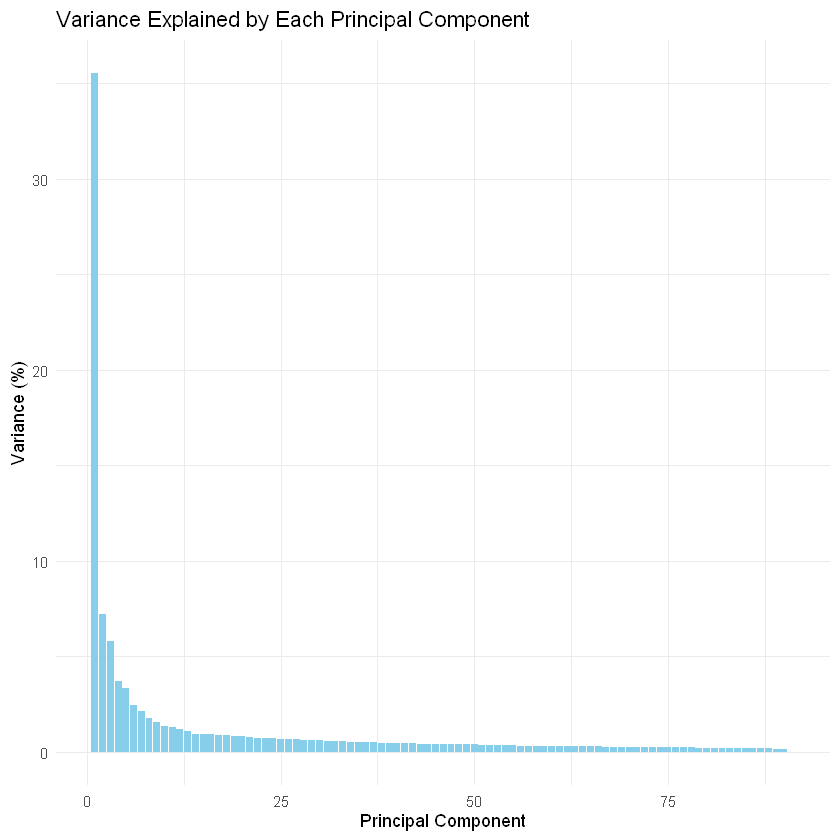

[1] "Current Time : 2024-12-08 20:10:14"
[1] "Standard PCA computation time : 1.075 seconds"


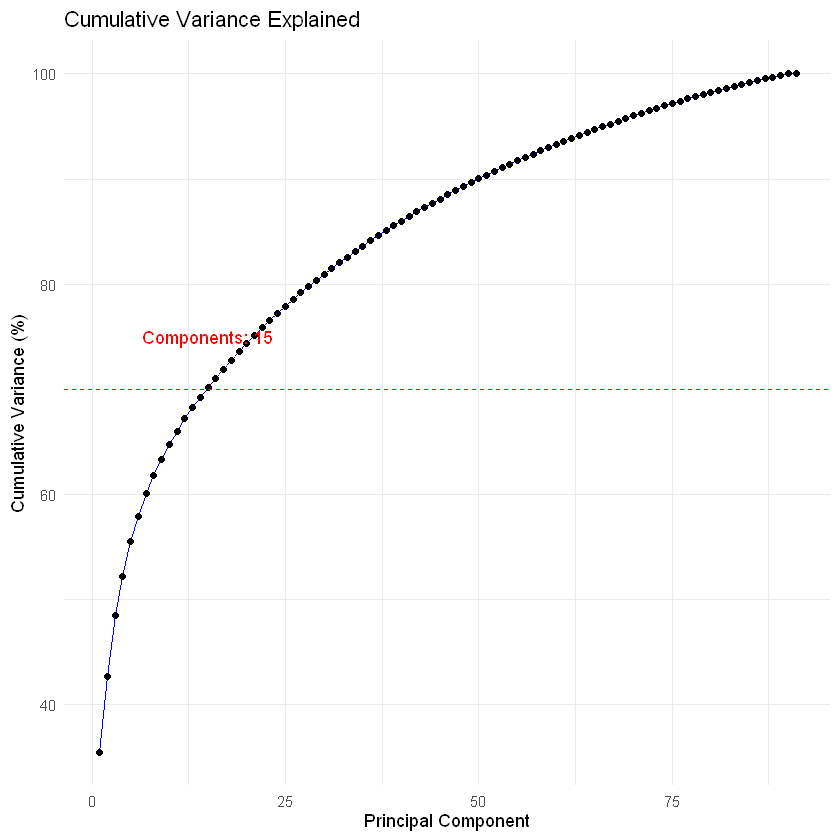

In [25]:
# PCA Exploration                        #
##########################################

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

oPCAAnalysis <- Analyze_PCA(oDataMatrix, numAxes = 15, explainedVarianceThreshold = 70)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

In [27]:
# Create the functions to compute the evaluation criteria

Get_RMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_RMSE() - Error : Input data contains NA value(s).")
  }
  return(sqrt(mean((rActual - rPredicted)^2, na.rm = TRUE)))
}

Get_MSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_MSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_MSE() - Error : Input data contains NA value(s).")
  }
  return(mean((rActual - rPredicted)^2, na.rm = TRUE))
}

Get_NMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_NMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_NMSE() - Error : Input data contains NA value(s).")
  }

  rMean_Squared_Error <- sum((rActual - rPredicted)^2)
  rMean_Variance_Error <- sum((rActual - mean(rActual))^2)

  if (rMean_Variance_Error == 0) {
    warning("Get_NMSE() - Error : Division / 0.")
    return(NA)
  }

  return(rMean_Squared_Error / rMean_Variance_Error)
}

# 4. Standard PCA

In [30]:
Perform_Standard_PCA <- function(trainData, testData, numComponents = NULL, varianceThreshold = NULL) {
  
  # Step 1: Select variables based on a variance threshold
  if (!is.null(varianceThreshold)) {
    colVariances <- apply(trainData, 2, var)  
    selectedCols <- colVariances > varianceThreshold
    trainData <- trainData[, selectedCols, drop = FALSE]
    testData <- testData[, selectedCols, drop = FALSE]
  } else {
    selectedCols <- rep(TRUE, ncol(trainData))
  }

  # Step 2: Define the number of components if not specified
  if (is.null(numComponents)) {
    numComponents <- ncol(trainData)
  }

  # Preprocessing: centering and scaling the training data
  X_train_scaled <- scale(trainData, center = TRUE, scale = TRUE)
  X_mean <- attr(X_train_scaled, "scaled:center")
  X_sd <- attr(X_train_scaled, "scaled:scale")

  # Perform PCA on the preprocessed data (not on the correlation matrix)
  # Since the data is already centered/scaled, set center=FALSE and scale.=FALSE in prcomp
  oPcaResult <- prcomp(X_train_scaled, center = FALSE, scale. = FALSE)

  # Visualization (optional)
  if (ncol(oPcaResult$x) >= 2) {
    plot(oPcaResult$x[, 1:2], main = "Standard PCA", xlab = "PC1", ylab = "PC2")
  }

  # Apply the same preprocessing to the test data
  X_test_scaled <- scale(testData, center = X_mean, scale = X_sd)

  # Project the test data onto the principal components
  # predict() can also be used directly, but here it's done manually:
  oTestScores <- X_test_scaled %*% oPcaResult$rotation[, 1:numComponents]

  # Reconstruct the test data
  X_test_reconstructed_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents])

  # Return to the original scale
  X_test_reconstructed <- sweep(X_test_reconstructed_scaled, 2, X_sd, "*")
  X_test_reconstructed <- sweep(X_test_reconstructed, 2, X_mean, "+")

  # Check dimensions
  if (!all(dim(X_test_reconstructed) == dim(testData))) {
    stop("Mismatch in dimensions between testData and reconstructed data")
  }

  # Evaluation
  dRMSE <- Get_RMSE(as.vector(testData), as.vector(X_test_reconstructed))
  dMSE <- Get_MSE(as.vector(testData), as.vector(X_test_reconstructed))
  dNMSE <- Get_NMSE(as.vector(testData), as.vector(X_test_reconstructed))

  result <- list(RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)
  if (!is.null(varianceThreshold)) {
    result$ActiveVariables <- sum(selectedCols)
  } else {
    result$ActiveVariables <- numComponents
  }

  return(result)
}

[1] "Current Time : 2024-12-08 20:10:21"
[1] "Number of Components: 21"


ERROR: Error in Get_RMSE(as.vector(testData), as.vector(X_test_reconstructed)): Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.


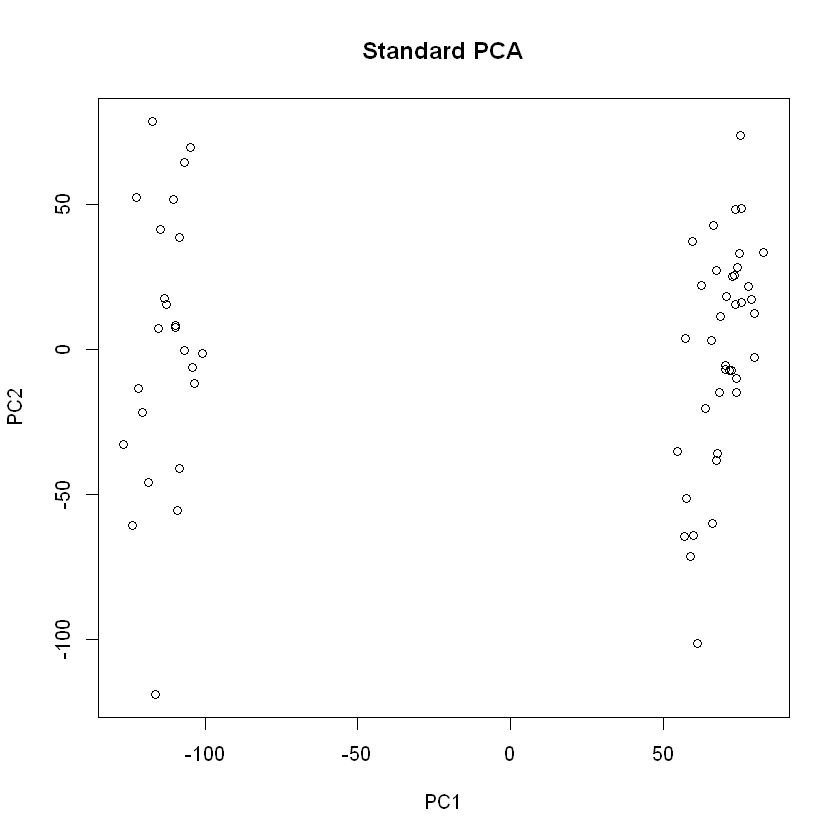

In [32]:
# Standard PCA on the Train DATASET      #
##########################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# First step => Find the number of components explaining 95% of the variance
oPCAResult <- prcomp(oTrainData, center = TRUE, scale. = TRUE)
dExplained_Variance <- cumsum(oPCAResult$sdev^2) / sum(oPCAResult$sdev^2)
iNumComponents <- which(dExplained_Variance >= 0.80)[1]
print(paste("Number of Components:", iNumComponents))

# Perform Standard PCA
oStandardPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, NULL)

print(paste("Standard PCA - RMSE:", oStandardPCAResults$RMSE))
print(paste("Standard PCA - MSE:", oStandardPCAResults$MSE))
print(paste("Standard PCA - NMSE:", oStandardPCAResults$NMSE))

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

# 5. PCA based on Variance Selection

[1] "Current Time : 2024-12-08 20:10:31"


ERROR: Error in Get_RMSE(as.vector(testData), as.vector(X_test_reconstructed)): Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.


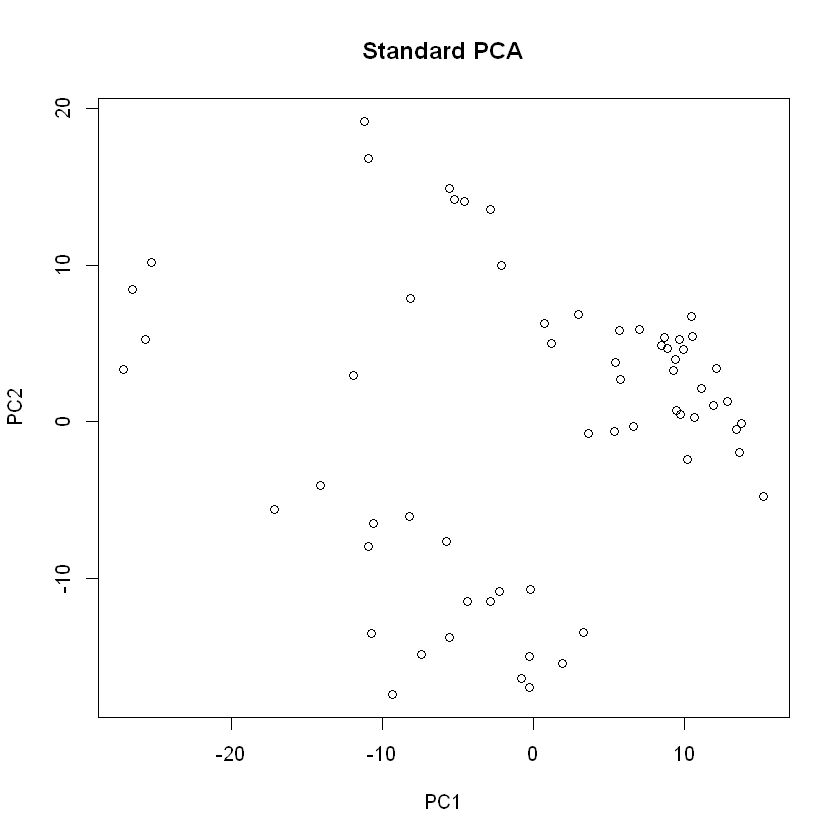

In [35]:
# Variance Selection PCA on the Train DATASET      #
####################################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Perform Variance Selection PCA
oVarPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, varianceThreshold = 1)

oVarPCAResults

# Display end time and elapsed time
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Variance Selection PCA computation time :", elapsed_time, "seconds"))

# 6. Sparse PCA

In [38]:
Perform_Sparse_PCA <- function(trainData, testData, paraValues, numComponents = 1) {
  library(elasticnet)
  
  # Data frame to store numeric results
  results <- data.frame(Para = paraValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # List to store loadings for each para value
  loadings_list <- list()
  
  # Parallel execution
  parallel_results <- foreach(i = 1:length(paraValues), .combine = rbind,
                              .packages = c("elasticnet"), 
                              .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    iPara <- paraValues[i]

    # HERE THE CALL WITH PRE-TREATMENT. Cor Matrix Sended to the fonction.
    # Preprocessing: scale trainData and compute covariance matrix
    X <- scale(trainData, center = TRUE, scale = TRUE)
    S <- cor(X)  # Matrice de corrélation
    # Perform Sparse PCA using the covariance matrix and type = "Gram"
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")

    # HERE THE CALL WITH RAW DATA      
    # oSparsePcaResult <- spca(trainData, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents))

      
    if (!is.null(oSparsePcaResult$loadings)) {
      # Scale testData with the same parameters used for trainData
      testDataScaled <- scale(testData, 
                              center = attr(X, "scaled:center"), 
                              scale = attr(X, "scaled:scale"))
      
      # Compute scores for test data in scaled space
      oTestScores <- testDataScaled %*% oSparsePcaResult$loadings
      
      # Reconstruct scaled test data
      oReconstructedScaled <- oTestScores %*% t(oSparsePcaResult$loadings)
      
      # Unscale the reconstructed data to original scale
      # First multiply by scale, then add center back
      oReconstructedData <- sweep(oReconstructedScaled, 2, attr(X, "scaled:scale"), "*")
      oReconstructedData <- sweep(oReconstructedData, 2, attr(X, "scaled:center"), "+")

      # Evaluate metrics using the original testData scale
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))
      
      # Count non-zero loadings
      non_zero_loadings <- sum(oSparsePcaResult$loadings != 0)
      
      cat("Para =", iPara, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Non-zero loadings:", non_zero_loadings, "\n")
      
      # Return iteration results
      data.frame(Para = iPara, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = non_zero_loadings)
    } else {
      cat("Para =", iPara, "- No valid loadings returned by spca\n")
      data.frame(Para = iPara, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
    }
  }
  
  # After parallel execution, we need to retrieve loadings in sequential mode.
  # If you want consistent results, use the same approach (covariance matrix + type = "Gram") here as well.
  X <- scale(trainData, center = TRUE, scale = TRUE)
  S <- cov(X)
  for (iPara in paraValues) {
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")
    if (!is.null(oSparsePcaResult$loadings)) {
      loadings_list[[as.character(iPara)]] <- oSparsePcaResult$loadings
    } else {
      loadings_list[[as.character(iPara)]] <- NULL
    }
  }
  
  results <- parallel_results
  
  # Return a list containing the results data frame and the loadings list
  return(list(results = results, loadings = loadings_list))
}

In [44]:
##########################################
# Sparse PCA on the entire Train DATASET #
##########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Penalty list
#oParaValues <- c(1, 2, 3, 5, 10, 15, 20, 25, 30)

oParaValues <- c(10)

# Perform Sparse PCA
res <- Perform_Sparse_PCA(oTrainData, oTestData, oParaValues, numComponents = 1)

oSparsePCAResults <- res$results
loadings_list <- res$loadings


print(oSparsePCAResults[, -6])

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 20:35:32"


ERROR: Error in {: task 1 failed - "impossible d'allouer un vecteur de taille 3.7 Go"


In [42]:
##########################################
# Sparse PCA Loadings Visual             #
##########################################

par(mfrow = c(ceiling(length(oParaValues)/6), 1))

for (iPara in oParaValues) {
  loadings <- loadings_list[[as.character(iPara)]]
  
  if (!is.null(loadings)) {
    barplot(loadings[, 1], main = paste("Loadings pour para =", iPara),
            xlab = "Variables", ylab = "Coefficient")
  } else {
    plot.new()
    title(main = paste("Pas de loadings pour para =", iPara))
  }
}

ERROR: Error: objet 'loadings_list' introuvable


In [ ]:
ggplot(oSparsePCAResults, aes(x = Para, y = ActiveVariables)) +
  geom_point() +
  geom_line() +
  labs(title = "Nombre de variables sélectionnées en fonction de para", x = "Para", y = "Nombre de variables")

In [ ]:
# Sparse PCA : Showing the best result  #
#########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

library(elasticnet)

variances <- apply(oTrainData, 2, var)

k <- 60 # Varaiables to keep
top_var_indices <- order(variances, decreasing = TRUE)[1:k]
x_reduced <- oTrainData[, top_var_indices]  # Jeu de données réduit

pca_sparse <- prcomp(x_reduced, center = TRUE, scale. = TRUE)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

In [ ]:
plot(pca_sparse$x[, 1:2], main = "Sparse PCA",
     xlab = "PC1", ylab = "PC2")

# THRESHOLD PCA

In [ ]:
Perform_Threshold_PCA <- function(trainData, testData, thresholdValues, numComponents = 1) {
  results <- data.frame(Threshold = thresholdValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(thresholdValues), .combine = rbind, 
                     .packages = c("stats"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    dThreshold <- thresholdValues[i]
    
    # Selecting variables with variance above the threshold
    oVariances <- apply(trainData, 2, var)
    oSelectedIndices <- which(oVariances > dThreshold)
    ActiveVariables <- length(oSelectedIndices)
    
    if (ActiveVariables > 0) {
      # Subset of selected variables
      oTrainDataSelected <- trainData[, oSelectedIndices, drop = FALSE]
      oTestDataSelected <- testData[, oSelectedIndices, drop = FALSE]

      # Centering and scaling on the selected training data
      X_train_selected_scaled <- scale(oTrainDataSelected, center = TRUE, scale = TRUE)
      X_mean <- attr(X_train_selected_scaled, "scaled:center")
      X_sd <- attr(X_train_selected_scaled, "scaled:scale")

      # PCA on the preprocessed selected data
      # Set center=FALSE, scale.=FALSE since centering/scaling is done manually
      oPcaResult <- prcomp(X_train_selected_scaled, center = FALSE, scale. = FALSE)

      # Apply the same preprocessing to the selected test data
      X_test_selected_scaled <- scale(oTestDataSelected, center = X_mean, scale = X_sd)
      
      # Project test data onto principal components
      oTestScores <- X_test_selected_scaled %*% oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE]

      # Reconstruct in scaled form
      X_test_reconstructed_selected_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE])

      # Return to the original scale for the selected subset
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected_scaled, 2, X_sd, "*")
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected, 2, X_mean, "+")

      # Place the reconstructed subset back into the full matrix (non-selected variables = 0)
      oReconstructedFull <- matrix(0, nrow = nrow(testData), ncol = ncol(testData))
      oReconstructedFull[, oSelectedIndices] <- X_test_reconstructed_selected

      # Evaluation
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedFull))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedFull))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedFull))
      
      # Store results
      result_row <- data.frame(Threshold = dThreshold, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = ActiveVariables)
      
      cat("Threshold =", dThreshold, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Num Variables:", ActiveVariables, "\n")
    } else {
      cat("Threshold =", dThreshold, "- No variables selected\n")
      result_row <- data.frame(Threshold = dThreshold, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = 0)
    }
    
    result_row
  }
  
  return(results)
}

In [ ]:
# Threshold PCA on the entire DATASET 01   #
############################################

# Cell execution time 15/11/2024 : 13.563 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Threshold list
thresholdValues <- seq(0.05, 1.5, by = 0.05)

# Perform Threshold PCA
oThresholdPCAResults <- Perform_Threshold_PCA(oTrainData, oTestData, thresholdValues, numComponents = 1)

print(oThresholdPCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Threshold PCA computation time :", elapsed_time, "seconds"))

In [ ]:
ggplot(oThresholdPCAResults, aes(x = ActiveVariables, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE en fonction du nombre de variables sélectionnées (Threshold PCA)",
       x = "Nombre de variables sélectionnées", y = "RMSE")

In [ ]:
ggplot(oThresholdPCAResults, aes(x = Threshold, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE ratio for variance Threshold (Threshold PCA)",
       x = "Variance Threshold", y = "RMSE")

# 7. RESULTS

In [ ]:
# Merging results array                 #
#########################################

library(reshape2)
library(tidyr)

# Convert named lists to numeric values
oStandardPCAResults$RMSE <- as.numeric(oStandardPCAResults$RMSE)
oStandardPCAResults$MSE <- as.numeric(oStandardPCAResults$MSE)
oStandardPCAResults$NMSE <- as.numeric(oStandardPCAResults$NMSE)
oVarPCAResults$RMSE <- as.numeric(oVarPCAResults$RMSE)
oVarPCAResults$MSE <- as.numeric(oVarPCAResults$MSE)
oVarPCAResults$NMSE <- as.numeric(oVarPCAResults$NMSE)
oSparsePCAResults$RMSE <- sapply(oSparsePCAResults$RMSE, as.numeric)
oSparsePCAResults$MSE <- sapply(oSparsePCAResults$MSE, as.numeric)
oSparsePCAResults$NMSE <- sapply(oSparsePCAResults$NMSE, as.numeric)
oThresholdPCAResults$RMSE <- sapply(oThresholdPCAResults$RMSE, as.numeric)
oThresholdPCAResults$MSE <- sapply(oThresholdPCAResults$MSE, as.numeric)
oThresholdPCAResults$NMSE <- sapply(oThresholdPCAResults$NMSE, as.numeric)

# New data frames
standardPCAResultsDF <- data.frame(Method = "Standard PCA", Parameter = 0, 
                                   RMSE = round(oStandardPCAResults$RMSE, 4), 
                                   MSE = round(oStandardPCAResults$MSE, 4), 
                                   NMSE = round(oStandardPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oStandardPCAResults$ActiveVariables))

variancePCAResultsDF <- data.frame(Method = "Variance PCA", Parameter = 0, 
                                   RMSE = round(oVarPCAResults$RMSE, 4), 
                                   MSE = round(oVarPCAResults$MSE, 4), 
                                   NMSE = round(oVarPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oVarPCAResults$ActiveVariables))

sparsePCAResultsDF <- data.frame(Method = "Sparse PCA", Parameter = oSparsePCAResults$Para, 
                                 RMSE = round(unlist(oSparsePCAResults$RMSE), 4), 
                                 MSE = round(unlist(oSparsePCAResults$MSE), 4), 
                                 NMSE = round(unlist(oSparsePCAResults$NMSE), 4),
                                 ActiveVariables = unlist(oSparsePCAResults$ActiveVariables))

thresholdPCAResultsDF <- data.frame(Method = "Threshold PCA", Parameter = oThresholdPCAResults$Threshold, 
                                    RMSE = round(unlist(oThresholdPCAResults$RMSE), 4), 
                                    MSE = round(unlist(oThresholdPCAResults$MSE), 4), 
                                    NMSE = round(unlist(oThresholdPCAResults$NMSE), 4),
                                    ActiveVariables = unlist(oThresholdPCAResults$ActiveVariables))                                    

# Combine all results
allResults <- rbind(standardPCAResultsDF, variancePCAResultsDF, sparsePCAResultsDF, thresholdPCAResultsDF)

# Cleaning
allResults$Parameter <- replace_na(allResults$Parameter, 0)

# Calculate Global_Score with rounded values
allResults <- allResults %>%
  mutate(Global_Score = round((RMSE + MSE + NMSE) / 3, 4))

print(allResults)

In [ ]:
library(dplyr)
library(ggplot2)


sortedResults <- allResults %>%
  arrange(NMSE) 


print(sortedResults)


bestMethod <- sortedResults %>%
  slice(1) 

cat("The best method is:", bestMethod$Method, "with a NMSE of", bestMethod$NMSE, "\n")

In [ ]:
bestResults <- allResults %>%
  group_by(Method) %>%
  filter(NMSE == min(NMSE, na.rm = TRUE)) %>%
  slice(1) %>%
  ungroup()

print(bestResults)

ggplot(bestResults, aes(x = reorder(Method, NMSE), y = NMSE, fill = Method)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Best NMSE for Each PCA Method",
    x = "PCA Method",
    y = "Normalized Mean Squared Error (NMSE)"
  ) +
  theme_minimal() +
  theme(legend.position = "none") +
  geom_text(aes(label = round(NMSE, 4)), vjust = -0.5, size = 3)

In [ ]:
ggplot(allResults, aes(x = Parameter, y = RMSE, color = Method)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE for PCA Methods", x = "(para or threshold)", y = "RMSE")

In [ ]:
# Computing a score                     #
#########################################

summaryDF <- allResults %>%
  group_by(Method) %>%
  summarise(
    Mean_RMSE = mean(RMSE),
    Mean_MSE = mean(MSE),
    Mean_NMSE = mean(NMSE)
  )

summaryDF <- summaryDF %>%
  mutate(Global_Score = (Mean_RMSE + Mean_MSE + Mean_NMSE) / 3)

print(summaryDF %>% arrange(Global_Score))  # Sorted by best global score...

In [ ]:
library(tidyr)

allResultsLong <- allResults %>%
  pivot_longer(cols = c("RMSE", "MSE", "NMSE"), names_to = "Metric", values_to = "Value")

ggplot(allResultsLong, aes(x = Parameter, y = Value, color = Method)) +
  geom_line(aes(linetype = Metric)) +
  geom_point() +
  labs(title = "Performance Metrics by PCA Method and Parameter",
       x = "Parameter Value",
       y = "Metric Value (Lower is Better)") +
  theme_minimal()

In [ ]:
library(dplyr)
library(ggplot2)

# Compute vertical scale
global_min <- min(allResults$Global_Score, na.rm = TRUE)
global_max <- max(allResults$Global_Score, na.rm = TRUE)

ggplot(allResults, aes(x = Parameter, y = Global_Score)) +
  geom_line(aes(group = Method), color = "blue") +
  geom_point(color = "blue") +
  geom_hline(data = allResults %>% filter(Method == "Standard PCA"),
             aes(yintercept = Global_Score), linetype = "dashed", color = "red") +
  facet_wrap(~ Method, scales = "free_x") +
  labs(title = "Global Performance Score by PCA Method",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  coord_cartesian(ylim = c(global_min, global_max))


In [ ]:
# Standard PCA
standardPCA <- allResults %>% filter(Method == "Standard PCA")

ggplot(standardPCA, aes(x = Parameter, y = Global_Score)) +
  geom_hline(aes(yintercept = Global_Score), color = "blue") +
  labs(title = "Global Performance Score - Standard PCA",
       x = "Parameter (Fixed at 0)",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

In [ ]:
# Sparse PCA
sparsePCA <- allResults %>% filter(Method == "Sparse PCA")
ggplot(sparsePCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "darkgreen") +
  geom_point(color = "darkgreen") +
  labs(title = "Global Performance Score by Parameter - Sparse PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

# Threshold PCA
thresholdPCA <- allResults %>% filter(Method == "Threshold PCA")
ggplot(thresholdPCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "purple") +
  geom_point(color = "purple") +
  labs(title = "Global Performance Score by Parameter - Threshold PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()